INFO:root:train accuracy
DEBUG:root:0.8024605433975073
DEBUG:root:0.701342893476763
DEBUG:root:0.680410530908473
DEBUG:root:0.6721137819244942
DEBUG:root:0.6645326230120436
DEBUG:root:0.6554212203885179
DEBUG:root:0.6441581063204794
DEBUG:root:0.6304741112824193
DEBUG:root:0.614288240229627
DEBUG:root:0.5957113583859297
DEBUG:root:0.5750452794850943
DEBUG:root:0.5527460851818905
DEBUG:root:0.5293583162135175
DEBUG:root:0.5054408272664842
DEBUG:root:0.4815048165811508
DEBUG:root:0.4579751493550333
DEBUG:root:0.43517549721757814
DEBUG:root:0.41333131863675326
DEBUG:root:0.3925830496055006
DEBUG:root:0.37300320203246945
DEBUG:root:0.35461332754941133
DEBUG:root:0.33739880108316084
DEBUG:root:0.32132072731160355
DEBUG:root:0.30632502349665275
DEBUG:root:0.29234906814874584
DEBUG:root:0.2793264002726065
DEBUG:root:0.26718992998375407
DEBUG:root:0.25587405003451974
DEBUG:root:0.24531595671553807
DEBUG:root:0.23545641454882188
DEBUG:root:0.22624013797787554
DEBUG:root:0.21761591542149442
DEBU

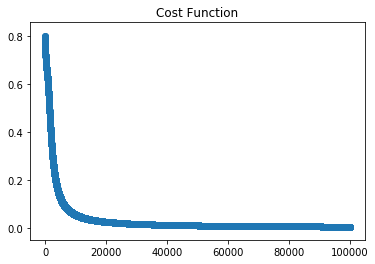

In [2]:
import numpy as np
from activation_helper import sigmoid
from make_dataset_helper import prepare_dataset
import logging
import matplotlib.pyplot as plt
% matplotlib inline


np.random.seed(0)
    

def initialize_parameter(layer_dims: list) -> dict:
    # generate parameter W, b
    parameters = {}
    for i in range(1, len(layer_dims)):
        parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i - 1]) * 0.01
        # Initialize in the accordance with He papers
        # parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * np.sqrt(2 / layer_dims[i - 1])
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))
    
    assert(parameters["W1"].shape == (layer_dims[1], layer_dims[0]))
    
    # test done
    return parameters

def forward_function(prev_A, W, b):
    Z = np.dot(W, prev_A) + b
    A = sigmoid(Z)    
    
    #test done
    return Z, A
    


def l_layer_forward(X, parameters, layer_dims):
    layer_num = len(layer_dims)
    outputs = {}
    outputs["A0"] = X
    for i in range(1, layer_num):
        prev_A = outputs["A" + str(i - 1)]
        W = parameters["W" + str(i)]
        b = parameters["b" + str(i)]
        Z, A = forward_function(prev_A, W, b)
        outputs["Z" + str(i)], outputs["A" + str(i)] = Z, A
        
        assert(outputs["Z" + str(i)].shape == outputs["A" + str(i)].shape)
        assert(outputs["Z" + str(i)].shape == (layer_dims[i], X.shape[1]))
    
    # test done
    return outputs

def caluculate_cost(AL, y, m):
    cost = - 1 / m * (np.dot(y, np.log(AL.T)) + np.dot((1 - y), np.log(1 - AL).T))
    return np.squeeze(cost)

def l_layer_backward(parameters, outputs, grads, layer_dims, y, m) -> dict:
    layer_num = len(layer_dims)
    AL = outputs["A" + str(layer_num - 1)]
    grads["dA" + str(layer_num - 1)] = -(y / AL) + (1 - y) / (1 - AL)
    for i in reversed(range(1, layer_num)):
        Z, A = outputs["Z" + str(i)], outputs["A" + str(i)]
        prev_A = outputs["A" + str(i - 1)]
        W = parameters["W" + str(i)]
        dA = grads["dA" + str(i)]
        dZ, dW, db, dprev_A = backward_function(dA, Z, A, prev_A, W, m)
        grads["dW" + str(i)], grads["db" + str(i)], grads["dA" + str(i - 1)] = dW, db, dprev_A
        assert(Z.shape == dZ.shape)
        assert(W.shape == dW.shape)
        
    return grads 

def backward_function(dA, Z, A, prev_A, W, m):
    # limited sigmoid
    dZ = dA * A * (1 - A)
    dW = 1 / m * np.dot(dZ, prev_A.T)
    db = 1/ m * np.sum(dZ, axis=1, keepdims=True)
    dprev_A = np.dot(W.T, dZ)
    return dZ, dW, db, dprev_A

def update_parameters(parameters, grads, layer_dims, learning_rate):
    for i in range(1, len(layer_dims)):
        parameters["W" + str(i)] -= learning_rate * grads["dW" + str(i)]
        parameters["b" + str(i)] -= learning_rate * grads["db" + str(i)]
    
    return parameters
    

def main(X, y, layer_dims, logger, learning_rate=0.01, iteration_num=100):
    # main function
    # valuable 
    # parameters - contain W and b on each layer as dictionary like "W1"
    # outputs - coutain Z and A on each layer as dictionary like "A1"
    parameters = initialize_parameter(layer_dims)
    str_AL = "A" + str(len(layer_dims) - 1)
    m = X.shape[1]
    costs = np.array([])
    for i in range(iteration_num):
        outputs = {}
        outputs = l_layer_forward(X, parameters, layer_dims)
        cost = caluculate_cost(outputs[str_AL], y, m)
        costs = np.append(costs, cost)
        
        grads = {}
        grads = l_layer_backward(parameters, outputs, grads, layer_dims, y, m)
        
        parameters = update_parameters(parameters, grads, layer_dims, learning_rate)
        
        if i % 100 == 0:
            logger.debug(cost)
            
    plt.title("Cost Function")
    plt.scatter(x=range(iteration_num),y=costs)
        

if __name__ == '__main__':
    logger = logging.getLogger()
    logging.basicConfig(level="DEBUG")
    X_train, X_test, y_train, y_test = prepare_dataset()
    layer_dims=[X_train.shape[0],3,1]
    logger.info("train accuracy")
    main(X_train, y_train, layer_dims,logger, learning_rate=0.01, iteration_num=1000)
    